# <font color="Sienna">Project: Forecasting Dog Adoption </font>
## Sornsawan Permpipat 300386177
Reference: 
- https://machinelearningmastery.com/types-of-classification-in-machine-learning
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
- frequency encoding: https://letsdatascience.com/frequency-encoding/
- Create Pie Chart: https://www.geeksforgeeks.org/how-to-create-pie-chart-from-pandas-dataframe
- Mapping in python: https://realpython.com/python-mappings
- Skewness: https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis
- Tuning the preprocessing: https://medium.com/@moritzkoerber/tune-your-preprocessing-steps-and-algorithm-selection-like-hyperparameters-c817e6572335
- Features Important for xgboost: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
- Multinomial Logistic Regression: https://machinelearningmastery.com/multinomial-logistic-regression-with-python


## <font color="Sienna"> Introduction </font>

**The Sonoma County Animal Shelter** is responsible for managing the intake, care, and placement of animals, including dogs.
This dataset, obtained from the Sonoma County government portal, records details of animal intakes and outcomes, including adoption, transfer, and other status types. This data can help shelters make data-driven decisions to improve adoption rates.

In this analysis, I focus exclusively on data related to dogs, examining trends in shelter intake, reasons for their stay, and outcomes over time. This targeted analysis aims to offer insights into the patterns of dog intake and adoption

- **Dataset**: https://data.sonomacounty.ca.gov/Government/Animal-Shelter-Intake-and-Outcome/924a-vesw/about_data

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold, SelectFromModel, RFE
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier

from Module import module as md

## <font color="Sienna"> Define the Problem  </font>

1.	What dog characteristics (breed, age, color, size, condition) are associated with adoption?
2.	Can a machine learning model predict if a dog is likely to be adopted, based on characteristics and shelter records?

## <font color="Sienna"> Gather and Preprocess Data </font>

In [8]:
df = pd.read_csv('Dataset/Animal_Shelter_Intake_and_Outcome_20241107.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Name                  12657 non-null  object 
 1   Type                  13640 non-null  object 
 2   Breed                 13640 non-null  object 
 3   Color                 13640 non-null  object 
 4   Sex                   13640 non-null  object 
 5   Size                  13614 non-null  object 
 6   Date Of Birth         13640 non-null  object 
 7   Impound Number        13640 non-null  object 
 8   Kennel Number         13637 non-null  object 
 9   Animal ID             13640 non-null  object 
 10  Intake Date           13640 non-null  object 
 11  Outcome Date          13520 non-null  object 
 12  Days in Shelter       13640 non-null  int64  
 13  Intake Type           13640 non-null  object 
 14  Intake Subtype        13640 non-null  object 
 15  Outcome Type       

In [9]:
# replace column name and and have a peek of the data
df.columns = df.columns.str.replace(' ','_')

In [10]:
# I need to convert some object columns into numbers to see the statistics for all columns but at this point I will take a peek at the data first
df.head()

,Name,Type,Breed,Color,Sex,Size,Date_Of_Birth,Impound_Number,Kennel_Number,Animal_ID,...,Intake_Type,Intake_Subtype,Outcome_Type,Outcome_Subtype,Intake_Condition,Outcome_Condition,Intake_Jurisdiction,Outcome_Jurisdiction,Outcome_Zip_Code,Location
0,PINTO,DOG,PIT BULL,BR BRINDLE/WHITE,Neutered,LARGE,07/27/2016,K19-032986,DA35,A389457,...,STRAY,FIELD,TRANSFER,HSSC,HEALTHY,HEALTHY,COUNTY,COUNTY,95407.0,"95407(38.4127094, -122.7412153)"
1,NaN,DOG,GERM SHEPHERD,TAN/BLACK,Female,LARGE,11/11/2021,K23-046766,DS80,A422038,...,STRAY,FIELD,EUTHANIZE,AGGRESSIVE,UNKNOWN,UNTREATABLE,COUNTY,NaN,NaN,NaN
2,FAUNA,DOG,GERM SHEPHERD,FAWN,Spayed,SMALL,06/08/2021,K24-047284,DS68,A423685,...,STRAY,OVER THE COUNTER,RETURN TO OWNER,NaN,UNKNOWN,HEALTHY,SANTA ROSA,NaN,93927.0,"93927(36.32153, -121.24627)"
3,TIMBER,DOG,ALASK MALAMUTE,BLACK/WHITE,Neutered,LARGE,08/21/2016,K23-043867,TRUCK,A391075,...,STRAY,FIELD,RETURN TO OWNER,FLD_MCHIP,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95409.0,"95409(38.457489, -122.644131)"
4,RUPI,DOG,RAT TERRIER,BLACK/WHITE,Spayed,SMALL,04/05/2013,K24-048650,DS69,A303391,...,STRAY,FIELD,RETURN TO OWNER,OVER THE COUNTER_WALKIN,UNKNOWN,PENDING,SANTA ROSA,SANTA ROSA,95401.0,"95401(38.445212, -122.745766)"


In [11]:
# Let's take a look at the statistics for numerical columns
df.describe()

,Days_in_Shelter,Outcome_Zip_Code
count,13640.000000,12576.000000
mean,21.322581,94891.427242
std,44.498434,4449.529982
min,0.000000,1922.000000
25%,1.000000,95401.000000
50%,9.000000,95405.000000
75%,25.000000,95439.000000
max,1239.000000,99323.000000


> **Explanation:** From the table the average shelter stay is approximately 21 days.

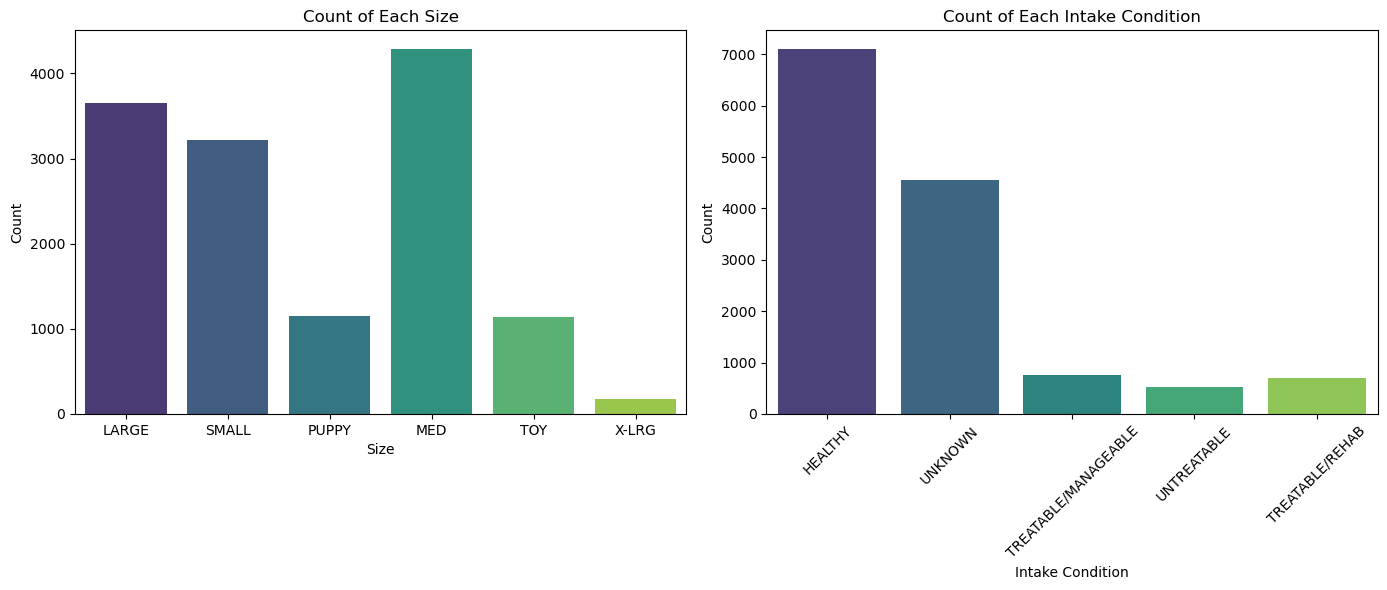

In [13]:
# Let's take a look at some interesting features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  

sns.countplot(data=df, x='Size', hue='Size', ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('Count of Each Size')
axes[0].set_xlabel('Size')
axes[0].set_ylabel('Count')

sns.countplot(data=df, x='Intake_Condition', hue='Intake_Condition', ax=axes[1], palette='viridis', legend=False)
axes[1].set_title('Count of Each Intake Condition')
axes[1].set_xlabel('Intake Condition')
axes[1].set_ylabel('Count')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to make sure everything fits
plt.tight_layout()

plt.savefig('Report/Images/size_and_Condition.png', format='png')

plt.show()


> **Explanation:** From the plot we can see that most dogs are healthy and medium size

In [15]:
#Let's take a look at the popular breed
df.Breed.value_counts()

Breed
PIT BULL                         1695
CHIHUAHUA SH                     1080
PIT BULL/MIX                      833
GERM SHEPHERD                     823
CHIHUAHUA SH/MIX                  514
                                 ... 
AMER ESKIMO/POMERANIAN              1
BRUSS GRIFFON/CHIHUAHUA SH          1
CHIHUAHUA LH/DACHSHUND              1
WELSH CORGI CAR/BORDER COLLIE       1
ALASKAN HUSKY/AUST KELPIE           1
Name: count, Length: 854, dtype: int64

> **Explanation:** From counting the data, we can see top 3 breeds include Pit Bull, Chihuahua ,and Germ shepherd.
>
> We will explore additional statistics and EDA as I proceed with cleaning and transforming the data.

### Data wrangling, transformation, and EDA

In [18]:
# Find duplicate records
df.duplicated().sum()

0

In [19]:
# Convert data into dates format
df['New_Outcome_Date'] = pd.to_datetime(df.Outcome_Date, errors='coerce')
df['DOB'] = pd.to_datetime(df.Date_Of_Birth , errors='coerce')

In [20]:
#Find the Age of each dog
df['Age'] = ((df['New_Outcome_Date'] - df['DOB']) / 365).dt.days

#drop the error row with age less than 0
error_date = df.loc[df.Age < 0].index
df = df.drop(error_date,axis=0)

# drop old date columns
df = df.drop(['Outcome_Date','Date_Of_Birth','New_Outcome_Date','DOB','Intake_Date'],axis=1)

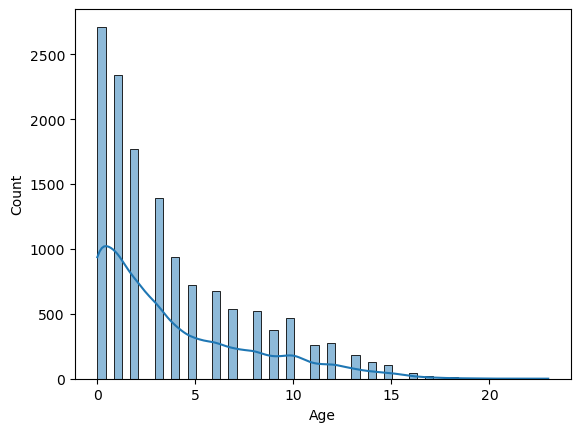

In [21]:
#Let's take a look at the age
plt.figure()
sns.histplot(df.Age,kde=True)
plt.show()

> **Explanation:** From the plot we can see that age has positive skewness, meaning it is right-skewed (many dogs are younger, and fewer are older) 

In [23]:
df.Outcome_Type.value_counts()

Outcome_Type
RETURN TO OWNER    6601
ADOPTION           3719
TRANSFER           1888
EUTHANIZE          1184
RTOS                 52
DIED                 32
DISPOSAL             25
VET                   2
ESCAPED/STOLEN        2
Name: count, dtype: int64

In [24]:
# The target variable (outcome_type) 4 popular values, I'll group rare outcome types into other
df['TargetMulti'] = df['Outcome_Type'].apply(lambda x: x if x in ['ADOPTION', 'RETURN TO OWNER', 'TRANSFER'] else 'OTHER')

# Here I only consider the main outcome_type so I'll drop the outcome_subtype and the old outcome_type column
df = df.drop(['Outcome_Subtype', 'Outcome_Type','Intake_Subtype'],axis=1)


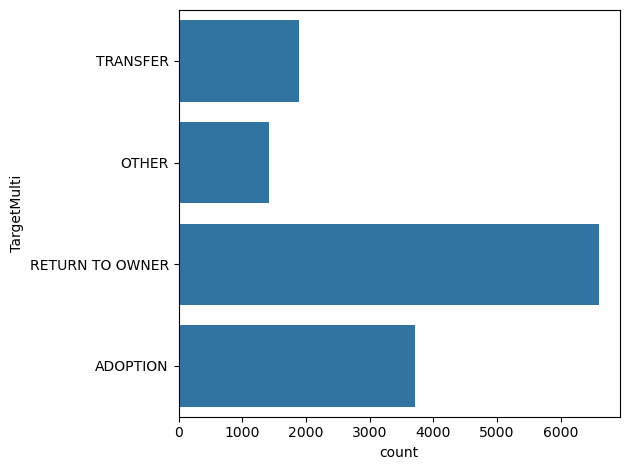

In [25]:
# Let's take a look at the target variable (outcome_type)
plt.figure()
sns.countplot(df.TargetMulti)

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig('Report/Images/Target.png', format='png')
plt.show()

> **Explanation:** From the bar plot, we can see that most of the dogs in this dataset has 'Return to their owners' follow by 'Adoption'

In [27]:
#In the dataset, the Breed column contains 856 unique values, including both popular and rare breeds. Instead of grouping breeds into broader categories, 
#I chose to retain their individuality because each breed might have unique characteristics that could influence the outcome
# so I'll use frequency encoding to assign each breed a numerical value based on its count
breed_frequency = df['Breed'].value_counts().to_dict()
df['Breed_Frequency'] = df['Breed'].map(breed_frequency)

# To keep track of the breed frequencies before dropping the original Breed column, I'll store the breed-to-frequency mapping in a separate DataFrame
breed_frequency = df['Breed'].value_counts().reset_index()
breed_frequency.columns = ['Breed', 'Frequency']

# drop the original 'Breed' column
df.drop(columns=['Breed'], inplace=True)

In [28]:
# In the sex column, there are 4 categories with sterilization, 
#I'll create a new column for Issterilization dogs such that 0 = is sterilized and 1 = not sterilized
df['Issterilization'] = df.Sex.apply(lambda x: 1 if x == 'Male' or x =='Female' or x == 'Unknown' else 0 )

In [29]:
# grouping Sex into 2 main type: 0 = male, 1 = female
df['Sex'] = df['Sex'].apply(lambda x: 0 if x in ['Male','Neutered'] else 1)


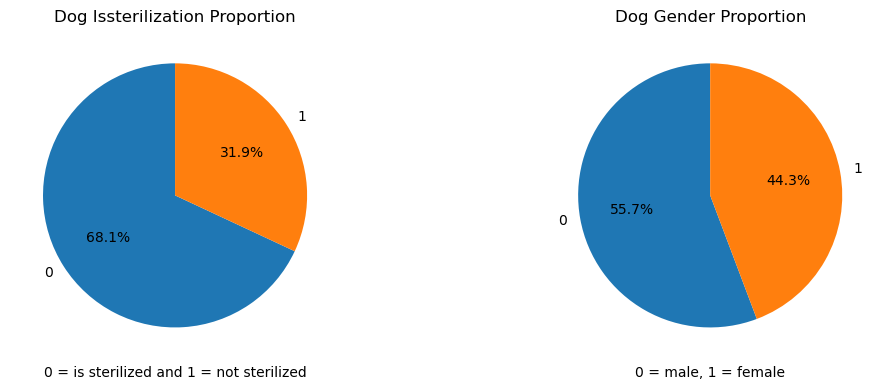

In [30]:
# Let's take a look at the Sex and sterilization count plot

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df['Issterilization'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[0])
axes[0].set_title('Dog Issterilization Proportion')
axes[0].set_ylabel('')
axes[0].set_xlabel('0 = is sterilized and 1 = not sterilized')

df['Sex'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axes[1])
axes[1].set_title('Dog Gender Proportion')
axes[1].set_ylabel('')
axes[1].set_xlabel('0 = male, 1 = female')

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig('Report/Images/sex_and_sterilization.png', format='png')
plt.show()

In [31]:
# In color columns there are 205 distinct values, I'll group them into 3 main colors: Monochrome, Brown, Brindle/Patterned/Tricolor, and Other.
# call the function from the module file
df['Grouped_Color'] = df['Color'].apply(md.categorize_color)

# drop old color column
df = df.drop(['Color'],axis=1)

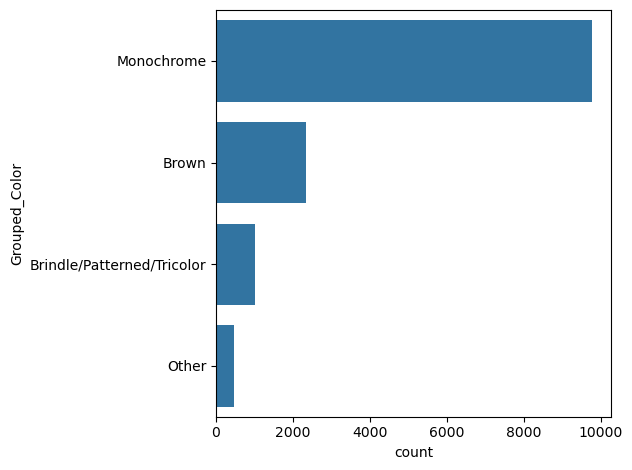

In [32]:
# Let's take a look at the color 
plt.figure()
sns.countplot(df.Grouped_Color)

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig('Report/Images/color.png', format='png')
plt.show()

> **Explanation:** From the bar plot, we can see that most of the dogs are monochrome color such as 'WHITE','BLACK', 'GRAY'.

In [34]:
# Drop uninterested columns 
# column that have unique identifiers for rows and don't hold any meaningful information about patterns in the dataset
# This project aims to predict whether the dog is 'ADOPTION': 0, 'EUTHANIZE': 1, 'OTHER': 2, 'RETURN TO OWNER': 3, 'TRANSFER': 4. 
# Thus, location information is not necessary in this project.

df = df.drop(['Name','Impound_Number','Kennel_Number','Animal_ID','Type','Location','Outcome_Condition','Intake_Type','Outcome_Zip_Code','Intake_Jurisdiction','Outcome_Jurisdiction'],axis=1)

### Feature Transformation

In [36]:
df.TargetMulti.value_counts()

TargetMulti
RETURN TO OWNER    6601
ADOPTION           3719
TRANSFER           1888
OTHER              1417
Name: count, dtype: int64

In [37]:
#  Encode Target Variable
label_encoder = LabelEncoder()
df['TargetMulti'] = label_encoder.fit_transform(df['TargetMulti'])

# Keep track of the target variables
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Encoded mapping:", class_mapping)

Encoded mapping: {'ADOPTION': 0, 'OTHER': 1, 'RETURN TO OWNER': 2, 'TRANSFER': 3}


In [38]:
# create dummy variable for categories columns
df = pd.get_dummies(df, dtype=int)

### Feature Engineering

In [40]:
# check for skewness in Age and Days_in_Shelter columns to improve model accuracy, stability, and interpretability.
df['Age_sqrt'] = np.sqrt(df['Age'])
df['Age_log'] = np.log(df['Age'] + 1)

df['daysShel_sqrt'] = np.sqrt(df['Days_in_Shelter'])
df['daysShel_log'] = np.log(df['Days_in_Shelter']+1)

#Let's try to see the skewness value of Age and Days_in_Shelter
original_skewness = df['Age'].skew()
log_skewness = df['Age_log'].skew()
sqrt_skewness = df['Age_sqrt'].skew()

original_skewness_d = df['Days_in_Shelter'].skew()
log_skewnes_d = df['daysShel_sqrt'].skew()
sqrt_skewness_d = df['daysShel_log'].skew()

print(f"Age Original Age Skewness: {original_skewness}")
print(f"Age Log Transformed Age Skewness: {log_skewness}")
print(f"Age Square Root Transformed Age Skewness: {sqrt_skewness}\n----")

print(f"DaysShel Original Skewness: {original_skewness_d}")
print(f"DaysShel Log Transformed Skewness: {log_skewnes_d}")
print(f"DaysShel Square Root Transformed Skewness: {sqrt_skewness_d}")

Age Original Age Skewness: 1.1845089465172767
Age Log Transformed Age Skewness: -0.011221340116619889
Age Square Root Transformed Age Skewness: 0.09927743907522751
----
DaysShel Original Skewness: 8.641534082983963
DaysShel Log Transformed Skewness: 1.7316309083900505
DaysShel Square Root Transformed Skewness: 0.11353019970317904


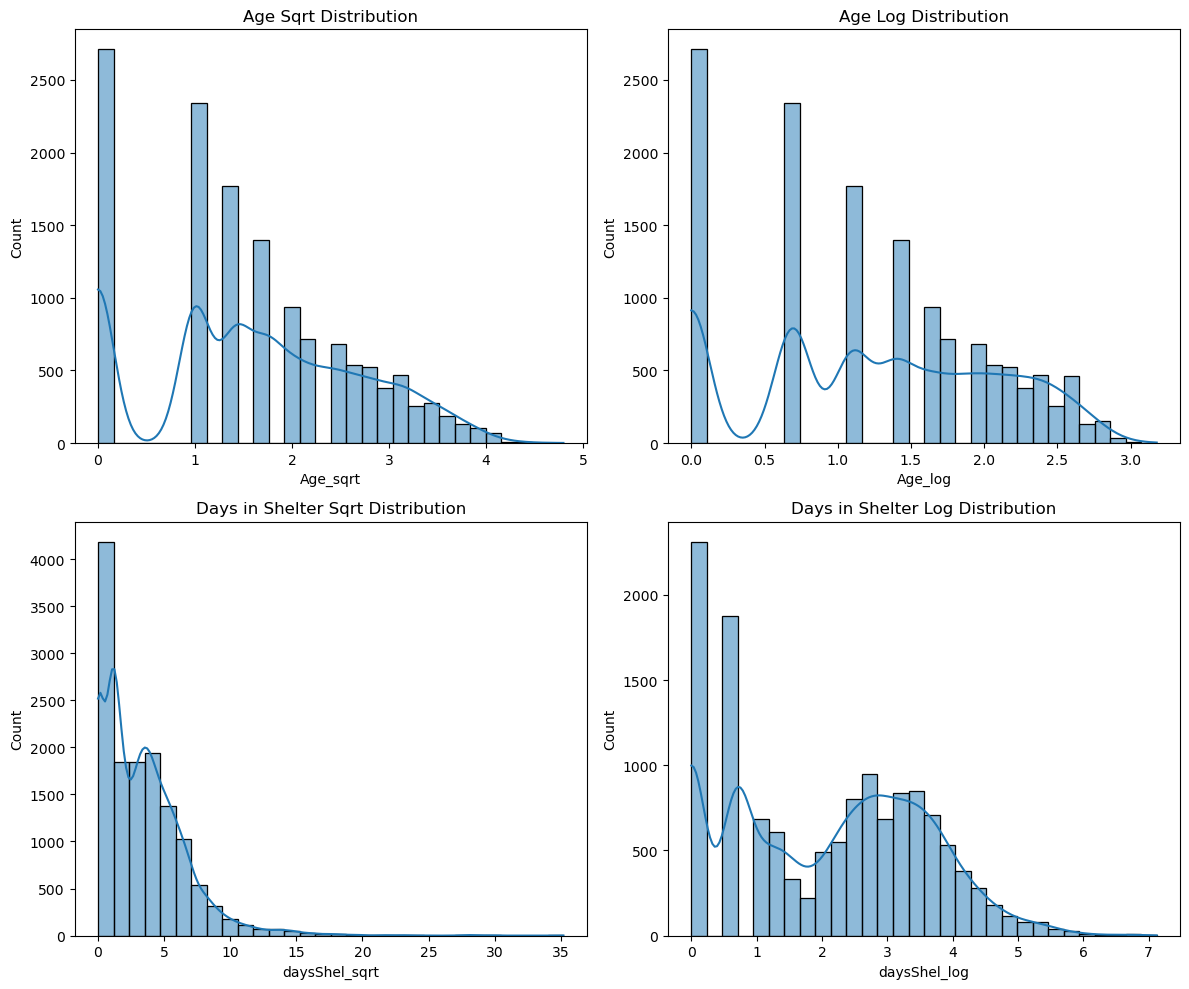

In [41]:
#Let's take a look at the plot to see the distribution
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot histograms
sns.histplot(df['Age_sqrt'], bins=30, kde=True, ax=axes[0, 0]).set(title='Age Sqrt Distribution')
sns.histplot(df['Age_log'], bins=30, kde=True, ax=axes[0, 1]).set(title='Age Log Distribution')
sns.histplot(df['daysShel_sqrt'], bins=30, kde=True, ax=axes[1, 0]).set(title='Days in Shelter Sqrt Distribution')
sns.histplot(df['daysShel_log'], bins=30, kde=True, ax=axes[1, 1]).set(title='Days in Shelter Log Distribution')

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig('Report/Images/age_and_dayInShelter_distrubution.png', format='png')
plt.show()

>**Explanation:**
>
>Based on the skewness values and the distribution plots
>
> For the Age, a log transformation is a more suitable approach. 
>
> For the Days_in_Shelter, the square root transformation is more effective in this case.

In [43]:
# drop unused Age and Days_in_Shelter after feature engineering
df = df.drop(['Age','Age_sqrt','daysShel_sqrt','Days_in_Shelter'],axis=1)

In [44]:
#drop null
df = df.dropna()

In [45]:
#Save the data frame
df.to_csv('Dataset/clened_Animal_Shelter_Intake_and_Outcome.csv',index=False)

In [46]:
# This is my dataset after cleaning and transformation
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 13505 entries, 0 to 13639
Data columns (total 21 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Sex                                       13505 non-null  int64  
 1   TargetMulti                               13505 non-null  int32  
 2   Breed_Frequency                           13505 non-null  int64  
 3   Issterilization                           13505 non-null  int64  
 4   Size_LARGE                                13505 non-null  int32  
 5   Size_MED                                  13505 non-null  int32  
 6   Size_PUPPY                                13505 non-null  int32  
 7   Size_SMALL                                13505 non-null  int32  
 8   Size_TOY                                  13505 non-null  int32  
 9   Size_X-LRG                                13505 non-null  int32  
 10  Intake_Condition_HEALTHY               

In [47]:
df.describe()

,Sex,TargetMulti,Breed_Frequency,Issterilization,Size_LARGE,Size_MED,Size_PUPPY,Size_SMALL,Size_TOY,Size_X-LRG,...,Intake_Condition_TREATABLE/MANAGEABLE,Intake_Condition_TREATABLE/REHAB,Intake_Condition_UNKNOWN,Intake_Condition_UNTREATABLE,Grouped_Color_Brindle/Patterned/Tricolor,Grouped_Color_Brown,Grouped_Color_Monochrome,Grouped_Color_Other,Age_log,daysShel_log
count,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,...,13505.000000,13505.000000,13505.00000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000,13505.000000
mean,0.441836,1.493003,497.231914,0.317290,0.268567,0.313217,0.083154,0.236653,0.083895,0.012588,...,0.055609,0.051240,0.33047,0.038652,0.074343,0.173047,0.717290,0.035320,1.230867,2.105187
std,0.496624,1.039418,567.749966,0.465439,0.443231,0.463819,0.276126,0.425043,0.277240,0.111492,...,0.229174,0.220496,0.47040,0.192772,0.262338,0.378302,0.450333,0.184595,0.841054,1.475533
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147
50%,0.000000,2.000000,213.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.098612,2.302585
75%,1.000000,2.000000,833.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,1.000000,0.000000,1.945910,3.295837
max,1.000000,3.000000,1694.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,3.178054,7.122867


## Featuer Selection

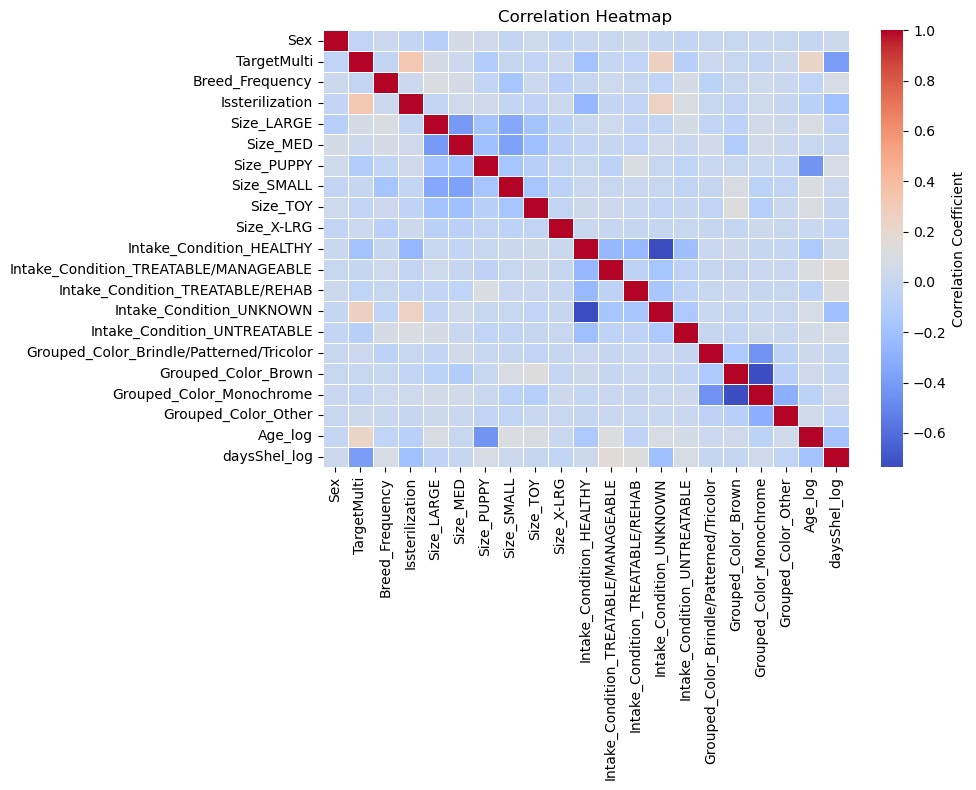

In [49]:
# Now let's take a look at the correlation matrix
corr_matrix = df.corr()

# Sort the correlation matrix
sorted_corr_matrix = corr_matrix.unstack().sort_values(ascending=False)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap')
# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig('Report/Images/heatmap.png', format='png')
plt.show()

In [50]:
# Let's take a look at top 5 variables with the highest correlation with the target variable
df.corr().sort_values(by=['TargetMulti'],ascending=False).abs().head(6)

,Sex,TargetMulti,Breed_Frequency,Issterilization,Size_LARGE,Size_MED,Size_PUPPY,Size_SMALL,Size_TOY,Size_X-LRG,...,Intake_Condition_TREATABLE/MANAGEABLE,Intake_Condition_TREATABLE/REHAB,Intake_Condition_UNKNOWN,Intake_Condition_UNTREATABLE,Grouped_Color_Brindle/Patterned/Tricolor,Grouped_Color_Brown,Grouped_Color_Monochrome,Grouped_Color_Other,Age_log,daysShel_log
TargetMulti,0.039701,1.000000,0.019451,0.334834,0.064276,0.022364,0.110337,0.007147,0.030213,0.019930,...,0.016242,0.041409,0.265306,0.088087,0.017388,0.001911,0.018465,0.024252,0.225343,0.396373
Issterilization,0.021230,0.334834,0.021734,1.000000,0.017880,0.038372,0.039575,0.020984,0.047913,0.018638,...,0.021025,0.026384,0.253648,0.110079,0.002158,0.035961,0.034062,0.006333,0.073708,0.199592
Intake_Condition_UNKNOWN,0.017725,0.265306,0.038285,0.253648,0.026501,0.049591,0.003488,0.001784,0.039420,0.005902,...,0.170482,0.163271,1.000000,0.140873,0.004325,0.015109,0.006200,0.009693,0.089723,0.202052
Age_log,0.017688,0.225343,0.041430,0.073708,0.097841,0.001350,0.435235,0.104423,0.103452,0.012572,...,0.113382,0.048950,0.089723,0.060188,0.021110,0.037624,0.062457,0.045265,1.000000,0.184140
Size_LARGE,0.086305,0.064276,0.104465,0.017880,1.000000,0.409216,0.182488,0.337392,0.183373,0.068418,...,0.031571,0.029436,0.026501,0.063969,0.025246,0.061671,0.054681,0.028866,0.097841,0.047892
Grouped_Color_Other,0.001418,0.024252,0.005377,0.006333,0.028866,0.015218,0.032928,0.033867,0.011550,0.000016,...,0.002581,0.000803,0.009693,0.005333,0.054227,0.087531,0.304787,1.000000,0.045265,0.040202


In [51]:
# split data in the beginning of the process to avoid data leakage
features = df.drop(['TargetMulti'],axis=1)
target = df.TargetMulti

#I use 80:20 for train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [52]:
# I'll be using multiple feature selection methods
feature_selectors = {  
    'All Features': 'passthrough',  # no selection, keep all features
    'SelectKBest': SelectKBest(score_func=f_classif, k=10),
    'VarianceThreshold': VarianceThreshold(threshold=0.2)
}

## Model Training and Evaluation

In [54]:
# Model training
results = []

# Define classifier names
names = [
    "Logistic Regression", "K-Nearest Neighbors", "Linear SVM", "RBF SVM",
    "Decision Tree", "Naive Bayes", "Random Forest", "XGBoost"
]

classifiers = [
    LogisticRegression(solver='lbfgs'),
    KNeighborsClassifier(n_neighbors=3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5,random_state=42),
    GaussianNB(),
    RandomForestClassifier(random_state=42),
    XGBClassifier(objective="multi:softmax", num_class=4, eval_metric='mlogloss',seed=42)                  
]

for selector_name, selector in feature_selectors.items():
    for idx, clf in enumerate(classifiers):
        clf_name = names[idx]
        
        # Build pipeline with feature selection, scaling, and classifier
        pipe = Pipeline(
            steps=[("features", selector),
                   ("scaler", RobustScaler()),
                   ("classifier", clf)]
        )
        
        
        pipe.fit(X_train, y_train)
        
        # Score and predict using the pipeline
        score = pipe.score(X_test, y_test)
        y_pred = pipe.predict(X_test)
        
        
        print(f"Model: {clf_name}")
        print(f"Model score: {score:.3f}")
        print(f"Selector: {selector_name}")
        print("\n----------------")

        
        results.append({
            'Selector': clf_name,
            'Feature': selector_name,
            'Accuracy': score,
            'Model': pipe,
            'Predictions': y_pred
        })




Model: Logistic Regression
Model score: 0.818
Selector: All Features

----------------
Model: K-Nearest Neighbors
Model score: 0.766
Selector: All Features

----------------
Model: Linear SVM
Model score: 0.807
Selector: All Features

----------------
Model: RBF SVM
Model score: 0.793
Selector: All Features

----------------
Model: Decision Tree
Model score: 0.791
Selector: All Features

----------------
Model: Naive Bayes
Model score: 0.762
Selector: All Features

----------------
Model: Random Forest
Model score: 0.812
Selector: All Features

----------------
Model: XGBoost
Model score: 0.824
Selector: All Features

----------------
Model: Logistic Regression
Model score: 0.816
Selector: SelectKBest

----------------
Model: K-Nearest Neighbors
Model score: 0.781
Selector: SelectKBest

----------------
Model: Linear SVM
Model score: 0.797
Selector: SelectKBest

----------------
Model: RBF SVM
Model score: 0.814
Selector: SelectKBest

----------------
Model: Decision Tree
Model score: 

In [55]:
# Convert results to DataFrame to easier see the result
results_df = pd.DataFrame(results)
results_df

,Selector,Feature,Accuracy,Model,Predictions
0,Logistic Regression,All Features,0.817845,"(passthrough, RobustScaler(), LogisticRegressi...","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."
1,K-Nearest Neighbors,All Features,0.766013,"(passthrough, RobustScaler(), KNeighborsClassi...","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."
2,Linear SVM,All Features,0.807108,"(passthrough, RobustScaler(), SVC(C=0.025, ker...","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."
3,RBF SVM,All Features,0.793040,"(passthrough, RobustScaler(), SVC(C=1, gamma=2))","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."
4,Decision Tree,All Features,0.791188,"(passthrough, RobustScaler(), DecisionTreeClas...","[0, 2, 2, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."
5,Naive Bayes,All Features,0.762310,"(passthrough, RobustScaler(), GaussianNB())","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 0, 2, 0, 0, ..."
6,Random Forest,All Features,0.812292,"(passthrough, RobustScaler(), (DecisionTreeCla...","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."
7,XGBoost,All Features,0.824139,"(passthrough, RobustScaler(), XGBClassifier(ba...","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."
8,Logistic Regression,SelectKBest,0.815994,"(SelectKBest(), RobustScaler(), LogisticRegres...","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."
9,K-Nearest Neighbors,SelectKBest,0.781192,"(SelectKBest(), RobustScaler(), KNeighborsClas...","[3, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."


### Finding the best model

In [57]:
# I'll find the best model by sorting it's accurency score
results_df.sort_values(by=['Accuracy'],ascending=False).head(1)

,Selector,Feature,Accuracy,Model,Predictions
7,XGBoost,All Features,0.824139,"(passthrough, RobustScaler(), XGBClassifier(ba...","[0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, ..."


In [58]:
# I'll get my best model by the index
ind_best = results_df.sort_values(by=['Accuracy'], ascending=False).head(1).index[0]
best_model = results_df.loc[ind_best, 'Model']
y_pred_best = results_df.loc[ind_best, 'Predictions']

In [59]:
best_model

Pipeline(steps=[('features', 'passthrough'), ('scaler', RobustScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None, num_class=4,
                               num_parallel_tree=None, ...))])

### Evaluate Model accuracy, precision, recall, and F1 score

In [61]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_best))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.89      0.82       720
           1       0.74      0.63      0.68       253
           2       0.91      0.93      0.92      1356
           3       0.61      0.43      0.50       372

    accuracy                           0.82      2701
   macro avg       0.76      0.72      0.73      2701
weighted avg       0.82      0.82      0.82      2701

Confusion Matrix:
 [[ 642    5   34   39]
 [  22  159   32   40]
 [  39   27 1266   24]
 [ 137   23   53  159]]


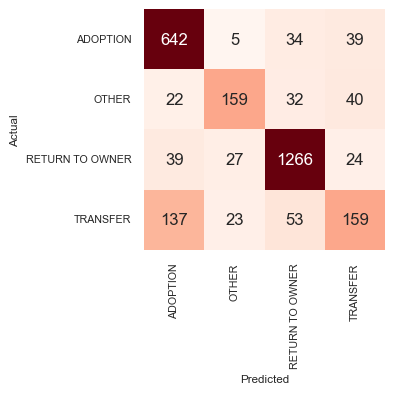

In [62]:
# Create heatmap for the confusion matrix
df_cm = pd.DataFrame(cm, 
                     columns=['ADOPTION', 'OTHER', 'RETURN TO OWNER', 'TRANSFER'], 
                     index=['ADOPTION', 'OTHER', 'RETURN TO OWNER', 'TRANSFER'])

# df_cm = pd.DataFrame(confusion_matrix, columns=np.unique(y_pred_best), index=np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize=(4,4))
sns.set(font_scale=0.7)
sns.heatmap(df_cm, annot=True, annot_kws={'size':12}, cbar=False,
           vmax=500, square=True, fmt='d', cmap='Reds')
# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig('Report/Images/confusion_matrix.png', format='png')
plt.show()

> **Explanation:**
>
> **From the confusion matrix and classification report**
The model performs well on the RETURN TO OWNER class with high precision and recall.
The ADOPTION class also has good performance, but there is some room for improvement in precision (with 76% precision).
The OTHER class has moderate performance, with a decent precision but relatively lower recall.
The model struggles with the TRANSFER class, with low precision and recall, meaning a large portion of instances are misclassified.
>
> Next let's try to improve the model with hyperparameter tunning

### Hyperparameter tuning xgboost

In [65]:
# Extract the classifier from the best model pipeline
best_classifier = best_model.named_steps['classifier']  

# Parameter grid for hyperparameter tuning
param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.1, 0.01, 0.001],
    'classifier__subsample': [0.5, 0.7, 1]
}

# Create a new pipeline with the scaling step (unchanged) and the classifier (with grid search)
pipeline_with_grid_search = Pipeline(steps=[
    ("feature", best_model.named_steps['features']),
    ('scaler', best_model.named_steps['scaler']),  # Use the existing scaler from best_model
    ('classifier', best_classifier)                
])

# Set up the GridSearchCV with the new pipeline and parameter grid
grid_search = GridSearchCV(pipeline_with_grid_search, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best set of hyperparameters:  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 7, 'classifier__subsample': 0.7}
Best score:  0.8172904348124155


In [66]:
grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature', 'passthrough'),
                                       ('scaler', RobustScaler()),
                                       ('classifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric='mlogloss',
                                                      feature_types=None,
                                                      gamma=Non...
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None, num_class=4,
                                                      num_parallel_tree=None, ...))]),
             param_grid={'classifier__learning_rate': [0.1, 0.01, 0.001],
                         'classifier__max_depth': [3, 5, 7],
                         'classifier__subsample': [0.5, 0.7, 1]},
             scoring='accuracy')

In [67]:
# Evaluate the Best Model on Test Data
y_pred_grid = grid_search.predict(X_test)

# Evaluate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred_grid)
print(f"Test Accuracy: {accuracy:.4f}")

print("Classification Report:\n", classification_report(y_test, y_pred_grid))

Test Accuracy: 0.8286
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83       720
           1       0.76      0.63      0.69       253
           2       0.92      0.93      0.92      1356
           3       0.64      0.41      0.50       372

    accuracy                           0.83      2701
   macro avg       0.77      0.72      0.74      2701
weighted avg       0.82      0.83      0.82      2701



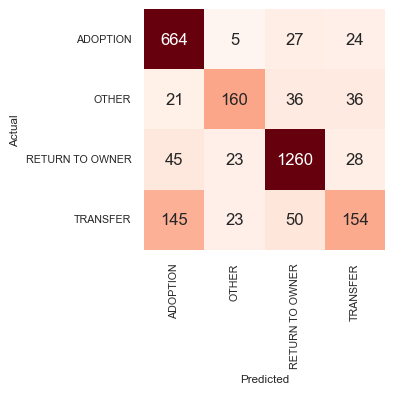

In [68]:
# Create heatmap for the confusion matrix
cm2 = confusion_matrix(y_test, y_pred_grid)
df_cm2 = pd.DataFrame(cm2, 
                     columns=['ADOPTION', 'OTHER', 'RETURN TO OWNER', 'TRANSFER'], 
                     index=['ADOPTION', 'OTHER', 'RETURN TO OWNER', 'TRANSFER'])

# df_cm = pd.DataFrame(confusion_matrix, columns=np.unique(y_pred_best), index=np.unique(y_test))
df_cm2.index.name = 'Actual'
df_cm2.columns.name = 'Predicted'
plt.figure(figsize=(4,4))
sns.set(font_scale=0.7)
sns.heatmap(df_cm2, annot=True, annot_kws={'size':12}, cbar=False,
           vmax=500, square=True, fmt='d', cmap='Reds')
# Adjust layout to make sure everything fits
plt.tight_layout()
plt.savefig('Report/Images/confusion_matrix_grid.png', format='png')
plt.show()

In [69]:
print(confusion_matrix(y_test, y_pred_best))

[[ 642    5   34   39]
 [  22  159   32   40]
 [  39   27 1266   24]
 [ 137   23   53  159]]


In [70]:
# Let's take a look at important features
#https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

# Extract the best model (classifier) from GridSearchCV
best_model_pipeline = grid_search.best_estimator_

# Extract the classifier (XGBClassifier) from the best pipeline
best_classifier = best_model_pipeline.named_steps['classifier']

feature_importances = best_classifier.feature_importances_

# Get the column names from X_train
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(sorted_feature_importance_df)

                                     Feature  Importance
13              Intake_Condition_UNTREATABLE    0.360463
2                            Issterilization    0.136818
19                              daysShel_log    0.091753
5                                 Size_PUPPY    0.061436
9                   Intake_Condition_HEALTHY    0.056963
11          Intake_Condition_TREATABLE/REHAB    0.035543
12                  Intake_Condition_UNKNOWN    0.031870
10     Intake_Condition_TREATABLE/MANAGEABLE    0.022941
3                                 Size_LARGE    0.022878
18                                   Age_log    0.022526
4                                   Size_MED    0.019523
6                                 Size_SMALL    0.019124
1                            Breed_Frequency    0.017340
7                                   Size_TOY    0.016829
0                                        Sex    0.015294
14  Grouped_Color_Brindle/Patterned/Tricolor    0.015100
16                  Grouped_Col

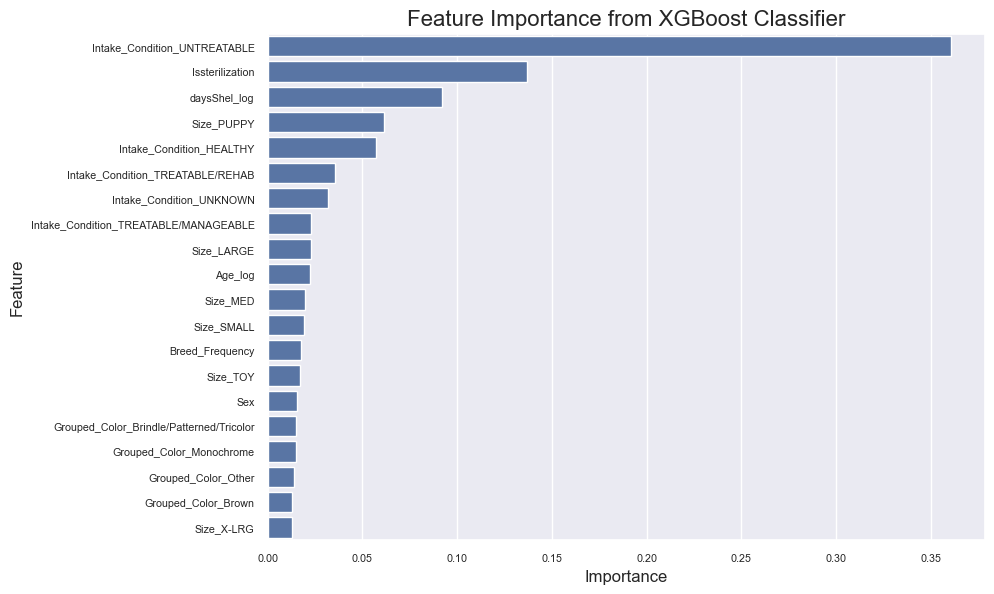

In [71]:
plt.figure(figsize=(10, 6))

# Create a bar plot for feature importances
sns.barplot(x='Importance', y='Feature', data=sorted_feature_importance_df)

# Set the title and labels
plt.title('Feature Importance from XGBoost Classifier', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.savefig('Report/Images/important_features.png', format='png')
# Show the plot
plt.show()

> **Explanation:** From the data we can see that The most important features in the model are those related to the animal’s condition, such as Intake_Condition_UNTREATABLE and Issterilization. Features related to size and color (e.g., Size_PUPPY, Grouped_Color_Brown) have a relatively lower impact on the predictions.

### Out of Sample Prediction

In [74]:
# create an out of sample prediction
dog_desc = X_test.describe()
dog_desc

,Sex,Breed_Frequency,Issterilization,Size_LARGE,Size_MED,Size_PUPPY,Size_SMALL,Size_TOY,Size_X-LRG,Intake_Condition_HEALTHY,Intake_Condition_TREATABLE/MANAGEABLE,Intake_Condition_TREATABLE/REHAB,Intake_Condition_UNKNOWN,Intake_Condition_UNTREATABLE,Grouped_Color_Brindle/Patterned/Tricolor,Grouped_Color_Brown,Grouped_Color_Monochrome,Grouped_Color_Other,Age_log,daysShel_log
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,0.457608,500.002592,0.330989,0.270270,0.306553,0.082932,0.238430,0.087005,0.013328,0.512773,0.060718,0.048871,0.341725,0.035913,0.071455,0.171418,0.723066,0.034061,1.220978,2.062385
std,0.498292,570.731630,0.470656,0.444182,0.461148,0.275831,0.426202,0.281894,0.114698,0.499929,0.238857,0.215638,0.474376,0.186107,0.257631,0.376944,0.447567,0.181421,0.844676,1.470113
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693147,0.693147
50%,0.000000,213.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.098612,2.197225
75%,1.000000,833.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.945910,3.258097
max,1.000000,1694.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.044522,6.763885


In [75]:
# use datafram for test data because I use dataframe in training the model
sel_dog_df = pd.DataFrame([dog_desc.loc['50%',:].values], columns=X_train.columns)
print(sel_dog_df)

   Sex  Breed_Frequency  Issterilization  Size_LARGE  Size_MED  Size_PUPPY  \
0  0.0            213.0              0.0         0.0       0.0         0.0   

   Size_SMALL  Size_TOY  Size_X-LRG  Intake_Condition_HEALTHY  \
0         0.0       0.0         0.0                       1.0   

   Intake_Condition_TREATABLE/MANAGEABLE  Intake_Condition_TREATABLE/REHAB  \
0                                    0.0                               0.0   

   Intake_Condition_UNKNOWN  Intake_Condition_UNTREATABLE  \
0                       0.0                           0.0   

   Grouped_Color_Brindle/Patterned/Tricolor  Grouped_Color_Brown  \
0                                       0.0                  0.0   

   Grouped_Color_Monochrome  Grouped_Color_Other   Age_log  daysShel_log  
0                       1.0                  0.0  1.098612      2.197225  


In [76]:
#predict class membership
y_pred_dog = grid_search.predict(sel_dog_df)

# predict probability
pred_prob_dog = grid_search.predict_proba(sel_dog_df)

In [77]:
#Display predicted class label
md.display_classLabel(y_pred_dog)

#Display predicted probability
md.display_PredProb(y_pred_dog, pred_prob_dog)

Predicted class membership for the dog is  [0] , which means  ADOPTION
Predicted probability for the dog is 0.76. The probability of adoption is 0.76


In [78]:
# Let's see the dog Breed 
breed_f = breed_frequency[breed_frequency['Frequency'] == 213]
print(breed_f)

                 Breed  Frequency
9  PARSON RUSS TER/MIX        213


> This buddy is ready to have a home :)